# Годовой проект - Определение популярности геолокации для размещения банкомата

`Куратор`: 
- Ковалева Александра  
    
`Команда`:
- Цуканов Николай Сергеевич
- Исхаков Ильдус Халитович
- Устименко Кирилл Александрович
- Волокитина Анастасия Евгеньевна

## Исходные данные

`id` - идентификатор банкомата  
`atm_group` - принадлежность банкомата к группе  
`address` - адрес банкомата на английском  
`address_rus` - адрес банкомата на русском  
`lat` - широта  
`long` - долгота    
`target` - целевая метрика  

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

Загрузим данные:

In [141]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [142]:
train_rows, train_columns = df_train.shape
test_rows, test_columns = df_test.shape
print(f'Данные для обучающей выборки состоят из {train_rows} строки и {train_columns} столбцов.') 
print(f'Данные для тестовой выборки состоят из {test_rows} строк и {test_columns} столбцов.') 

Данные для обучающей выборки состоят из 6261 строки и 7 столбцов.
Данные для тестовой выборки состоят из 2504 строк и 6 столбцов.


Посмотрим на наши наблюдения:

In [138]:
df_train.sample(5)

,id,atm_group,address,address_rus,lat,long,target
5995,"7,869.00","5,478.00","D. 31, UL. KOL'COVSKAYA VORONEZH G","Кольцовская улица, 31, Воронеж, Россия, 394030",51.67,39.19,-0.05
3233,"6,203.00","5,478.00","D. 90, PR-KT AVIATOROV YAROSLAVL G","проспект Авиаторов, 90, Ярославль, Россия, 150062",57.66,39.94,-0.00
4363,"5,262.00","5,478.00","D. 11, KORP. A, UL. D'YAK NIZHNIY NOVG","улица Минина, 11А, Нижний Новгород, Россия",56.33,44.02,0.03
556,"4,979.00","5,478.00","D. 28, UL. GAGARINA YAROSLAVL G","улица Гагарина, 28, Ярославль, Россия, 150046",57.58,39.84,-0.03
2883,"2,104.00","3,185.50","MONTAZHNIKOV, 2 ORENBURG","улица Монтажников, 2, Оренбург, Россия, 460048",51.80,55.14,-0.03


## Изучим данные:

Посмотрим на типы данных:

In [139]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6261 entries, 0 to 6260
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6261 non-null   float64
 1   atm_group    6261 non-null   float64
 2   address      6261 non-null   object 
 3   address_rus  5957 non-null   object 
 4   lat          5957 non-null   float64
 5   long         5957 non-null   float64
 6   target       6261 non-null   float64
dtypes: float64(5), object(2)
memory usage: 391.3+ KB


Посмотрим на наличие пропусков:

In [140]:
df_train.isna().sum()

id               0
atm_group        0
address          0
address_rus    304
lat            304
long           304
target           0
dtype: int64

In [15]:
data_gaps = round(100 * (df_train.shape[0] - df_train[df_train['address_rus'].notna()].shape[0]) / df_train.shape[0], 2)

In [16]:
print(f'Имеется 304 банкомата ({data_gaps}% от общего числа) без указания адреса на русском и географических координат.')

Имеется 304 банкомата (4.86% от общего числа) без указания адреса на русском и географических координат.


Посмотрим на наличие полных дублей:

In [18]:
df_train.duplicated().sum()

0

Дубли отсутствуют.

Посмотрим на количественные переменные:

In [120]:
pd.options.display.float_format = '{:,.2f}'.format

In [121]:
df_train.describe(include='number')

,id,atm_group,lat,long,target,len_address,len_postal_code,count
count,"6,261.00","6,261.00","5,957.00","5,957.00","6,261.00","5,957.00","4,698.00","6,261.00"
mean,"4,419.12","4,417.94",54.16,63.52,0.00,59.36,6.00,1.00
std,"2,547.21","2,430.41",4.35,33.02,0.09,16.14,0.00,0.00
min,5.00,32.00,42.06,19.94,-0.15,27.00,6.00,1.00
25%,"2,228.00","1,942.00",52.25,37.86,-0.06,46.00,6.00,1.00
50%,"4,392.00","5,478.00",55.07,48.58,-0.02,58.00,6.00,1.00
75%,"6,660.00","5,478.00",56.12,84.95,0.04,68.00,6.00,1.00
max,"8,811.00","8,083.00",69.49,173.71,0.22,144.00,6.00,1.00


In [122]:
df_test.describe(include='number')

,id,atm_group,lat,long
count,"2,504.00","2,504.00","2,388.00","2,388.00"
mean,"4,368.24","4,379.68",54.08,63.45
std,"2,530.93","2,421.99",4.29,32.21
min,1.00,32.00,42.65,20.44
25%,"2,146.50","1,942.00",52.21,37.81
50%,"4,437.50","5,478.00",55.04,49.15
75%,"6,468.50","5,478.00",56.10,84.95
max,"8,808.00","8,083.00",69.50,160.85


Широта может иметь значения от 0 до 90 градусов, долгота - от 0 до 180 градусов. Наши наблюдения не выходят за рамки этих пределов.  

Посмотрим на категориальные переменные:

In [20]:
df_train.describe(include='object')

,address,address_rus
count,6261,5957
unique,5343,4553
top,"HOROSHEVSKOE SH,V38 MOSKVA","улица Ватутина, 107, Новосибирск, Россия, 630024"
freq,7,8


In [123]:
df_test.describe(include='object')

,address,address_rus
count,2504,2388
unique,2138,1952
top,30/32 KUTUZOVSKIY PR. MOSCOW,"Кутузовский проспект, 30, Москва, Россия, 121165"
freq,6,6


Посмотрим сколько банкоматов принадледит той или иной группе:

In [21]:
df_train.groupby('atm_group', as_index=False).agg(Банкоматов=('atm_group', 'count')).sort_values(by='Банкоматов', ascending=False)

,atm_group,Банкоматов
5,5478.0,2662
3,1942.0,1160
6,8083.0,1050
1,496.5,616
4,3185.5,594
2,1022.0,136
0,32.0,43


Уберем возможные пробелы для наших записей:

In [22]:
df_train['address_rus'] = df_train['address_rus'].apply(lambda x: x.strip() if pd.notnull(x) else None)

Посмотрим на длину записей адресов:

In [23]:
df_train['len_address'] = df_train['address_rus'].apply(lambda x: len(x) if x != None else None)

In [24]:
df_train['len_address'].min(), df_train['len_address'].max()

(27.0, 144.0)

Посмотрим на самый длинный адрес в наших данных:

In [25]:
df_train[df_train['len_address'] == 144]['address_rus'].loc[3579]

'Волжская улица, 1, посёлок городского типа Ванино, городское поселение Рабочий Посёлок Ванино, Ванинский район, Хабаровский край, Россия, 682860'

Каких-то аномально длинных адресов нет.

Посмотрим на формат записей адресов банкоматов на русском:

In [26]:
df_train['address_rus'][0]

'улица А.О. Емельянова, 34, Южно-Сахалинск, Сахалинская область, Россия'

In [27]:
df_train['address_rus'][10]

'Большая Московская улица, 90А, Владимир, Россия, 600000'

In [28]:
df_train['address_rus'][1343]

'Магаданская улица, 31, посёлок Хандыга, Томпонский муниципальный район, Республика Саха (Якутия), Россия, 678720'

Спарсим наши адреса на русском на составляющие: `почтовый индекс`, `страна`, `город`, `улица`, `дом`:

__1. Достанем из адреса почтовый индекс, если он имеется:__

In [33]:
def get_postal_code(address: str):
    address = address.split(', ')
    if address[-1].isdigit():
        return address[-1]
    else:
        return None

In [34]:
df_train['postal_code'] = df_train['address_rus'].apply(lambda x: get_postal_code(x) if pd.notnull(x) else None)

В России принята 6-значная система почтовых индексов XXXYYY, где XXX - код субъекта федерации, YYY - номер почтового отделения в нем, но крупные города, такие как, например, Москва имеет несколько кодов. Проверим какой длины имеющиеся индексы в наших данных:

In [35]:
df_train['len_postal_code'] = df_train['postal_code'].apply(lambda x: len(x) if pd.notnull(x) else None)

In [36]:
df_train['len_postal_code'].unique()

array([nan,  6.])

Все почтовые индексы имеют нужную длину.

__2. Достанем из адреса страну, если она имеется:__

In [38]:
def get_country(address: str):
    address = address.split(', ')
    if address[-1].isalpha():
        return address[-1]
    elif address[-2].isalpha():
        return address[-2]
    else:
        return None

In [39]:
df_train['country'] = df_train['address_rus'].apply(lambda x: get_country(x) if pd.notnull(x) else None)

In [40]:
df_train['country'].unique()

array(['Россия', None], dtype=object)

Без неожиданностей - все адреса банкоматов в России.

__3. Достанем из адреса город, если он имеется:__

Возьмем список городов России из Википедии:

In [41]:
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
test = pd.read_html(url)[0]
cities = test['Город']

In [42]:
cities

0           Абаза
1          Абакан
2        Абдулино
3          Абинск
4         Агидель
          ...    
1120    Ярославль
1121       Ярцево
1122    Ясногорск
1123        Ясный
1124       Яхрома
Name: Город, Length: 1125, dtype: object

In [43]:
def get_city(address: str):
    for city in cities:
        if city in address:
            return city
        else:
            None

In [44]:
df_train['city'] = df_train['address_rus'].apply(lambda x: get_city(x) if pd.notnull(x) else None)

Посмотрим какая доля записей осталась без города среди адресов, которые имеют запись на русском:

In [45]:
no_city = round(100 * df_train[(df_train['address_rus'].notna()) & (df_train['city'].isnull())].shape[0] / df_train[df_train['address_rus'].notna()].shape[0], 1)

In [61]:
print(f'{no_city}%')

1.4%


__4. Достанем из адеса улицу, если она имеется:__

Регулярное выражение, чтобы достать из адреса название улицы, когда сперва идет слово `улица`, а потом название:

In [59]:
second_street_pattern = r"(улица)([А-Яа-яё0-9-\s+\.]+)"

Регулярное выражение, чтобы достать из адреса название улицы, когда сперва идет название, а потом слово `улица`:

In [60]:
first_street_pattern = r"([А-Яа-яё0-9-\s+\.]+)(улица)"

Регулярное выражение, чтобы достать название улицы, когда сперва идут слова `проспект`, `проезд`, `переулок`, `набережная`, `площадь`, `бульвар`, `шоссе`, `тракт`, `квартал`, `микрорайон`, а потом название:

In [62]:
second_group_street_patterns = [r"(проспект)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(проезд)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(переулок)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(набережная)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(площадь)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(бульвар)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(шоссе)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(тракт)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(квартал)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(микрорайон)([А-Яа-яё0-9-\s+\.]+)"]

Регулярное выражение, чтобы достать название улицы, когда сперва идет название, а потом слова `проспект`, `проезд`, `переулок`, `набережная`, `площадь`, `бульвар`, `шоссе`, `тракт`, `квартал`, `микрорайон`:

In [63]:
first_group_street_patterns = [r"([А-Яа-яё0-9-\s+\.]+)(проспект)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(проезд)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(переулок)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(набережная)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(площадь)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(бульвар)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(шоссе)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(тракт)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(квартал)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(микрорайон)"]

Регулярное выражение, чтобы достать `номер дома`:

In [64]:
number_pattern = r"([\d][0-9а-жёА-Ж\.\/]+|(\d+))"

In [66]:
def get_part_street_name(address: str):
    try:
        name_street = re.search(second_street_pattern, address).group(2)
        return name_street.strip()
    except:
        name_street = None
    
    try:
        name_street = re.search(first_street_pattern, address).group(1)
        return name_street.strip()
    except:
        name_street = None
        
    for pattern in second_group_street_patterns:
         try:
            name_street = re.findall(pattern, address)
            return (name_street[0][0] + name_street[0][1]).strip()
         except:
            name_street = None
            
    for pattern in first_group_street_patterns:
         try:
            name_street = re.findall(pattern, address)
            return (name_street[0][0] + name_street[0][1]).strip()
         except:
            name_street = None
    return name_street

In [67]:
df_train['street_name'] = df_train['address_rus'].apply(lambda x: get_part_street_name(x))

Посмотрим адреса, которые есть на русском и к которым мы не смогли достать название улицы:

In [68]:
empty_street = df_train[(df_train['address_rus'].notna()) & (df_train['street_name'].isnull())]
empty_street['address_rus'].head(20)

8      деревня Веледниково, городской округ Истра, Мо...
30               19-я линия, 10, Иваново, Россия, 153031
145    метро Площадь Габдуллы Тукая, Центральная лини...
189    автодорога Красноярск-Железногорск, 20 км, Бер...
249    срезка на 5 км, территория Спортивный клуб Ром...
299    Буденновский лес, Красногвардейский район, Бел...
300    Буденновский лес, Красногвардейский район, Бел...
317    посёлок Красный Бор, 1, Ярославский район, Яро...
400    посёлок Ростовка, 23, Омский район, Омская обл...
438    СНТ 60 лет Октября, 60, Старый Оскол, Белгород...
456    садовое товарищество Грибники, Венёвский район...
497    А-181 Скандинавия, 132-й километр, Выборгский ...
510    деревня Колпино, Краснохолмский район, Тверска...
582    КАД, 29-й километр, внешнее кольцо, Санкт-Пете...
590    СНТ Выбор, 194, село Немчиновка, Одинцовский р...
594    посёлок Молодёжный, 14, городской округ Подоль...
596    КАД, 29-й километр, внешнее кольцо, Санкт-Пете...
665    поселок Новые Лапсары, г

In [69]:
empty_street.isna().sum()

id                   0
atm_group            0
address              0
address_rus          0
lat                  0
long                 0
target               0
len_address          0
postal_code        154
len_postal_code    154
country              0
city                20
street_name        157
dtype: int64

In [70]:
steet_gaps = round(100 * empty_street['street_name'].isna().sum() / df_train[df_train['address_rus'].notna()].shape[0],1)
print(f'Таких адресов получилось {steet_gaps}%.')

Таких адресов получилось 2.6%.


__5. Достанем номера домов для адресов, из которых удалось достать название улицы:__

In [72]:
def get_number(address: str):
    try:
        number = re.search(number_pattern, address).group(0)
        return number.strip()
    except:
        number = None
    return number

In [73]:
df_train['number'] = df_train[df_train['address_rus'].notna()]['address_rus'].apply(lambda x: get_number(x.split(', ')[1]))

In [76]:
df_train.sample(5)

,id,atm_group,address,address_rus,lat,long,target,len_address,postal_code,len_postal_code,country,city,street_name,number
5206,499.0,1942.0,VOKZALNAYA 4 B RAMENSKOE MO,"Вокзальная улица, 4, Раменское, Московская обл...",55.566603,38.224537,0.045917,66.0,140100,6.0,Россия,Раменское,Вокзальная,4
1769,8399.0,5478.0,"D. 22, UL. LENINA PROTVINO G","улица Ленина, 22, Протвино, Московская область...",54.873429,37.220580,-0.057288,62.0,142281,6.0,Россия,Протвино,Ленина,22
5989,7801.0,5478.0,"D. 23, UL. KASPIISKAYA NIZHNIY TAGI","Каспийская улица, 23, Нижний Тагил, Свердловск...",57.852597,60.034842,-0.086901,72.0,622015,6.0,Россия,Каспийск,Каспийская,23
1957,6085.0,5478.0,"D. 99, PR-KT LENINA BRYANSK G","проспект Ленина, 99, Брянск, Россия, 241050",53.251956,34.373720,-0.028007,43.0,241050,6.0,Россия,Брянск,проспект Ленина,99
393,2184.0,3185.5,"NEFTEZAVODSKAJA,53 OMSK","Нефтезаводская улица, 53, Омск, Россия, 644065",55.058275,73.250703,-0.124397,46.0,644065,6.0,Россия,Омск,Нефтезаводская,53


Посмотрим какое количество городов представлено в наших данных:

In [54]:
df_train['city'].nunique()

422

Выведем топ-10 городов по численности банкоматов по городам:

In [77]:
top_10_atms = df_train.groupby('city', as_index=False).agg(atm=('id', 'count')).sort_values(by='atm', ascending=False).head(10)

In [78]:
top_10_atms['share,%'] = round(100 * top_10_atms['atm'] / df_train.shape[0], 1)

In [80]:
top_10_atms

,city,atm,"share,%"
262,Москва,504,8.0
207,Красноярск,214,3.4
343,Санкт-Петербург,176,2.8
287,Новосибирск,138,2.2
184,Киров,126,2.0
203,Краснодар,121,1.9
296,Омск,114,1.8
78,Владивосток,99,1.6
130,Екатеринбург,94,1.5
10,Амурск,91,1.5


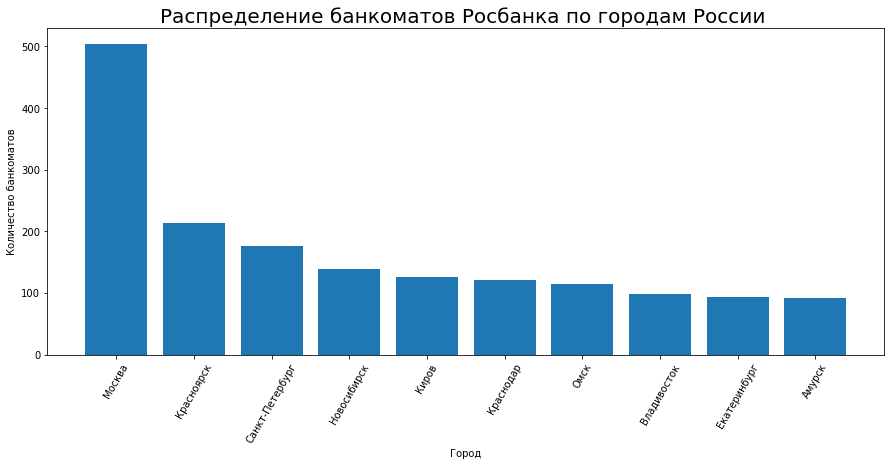

In [109]:
plt.figure(figsize=(15, 6))
plt.bar(x=top_10_atms['city'], height=top_10_atms['atm'])
plt.title('Распределение банкоматов Росбанка по городам России ', fontsize=20)
sns.color_palette('pastel')
plt.xticks(rotation=60)
plt.xlabel('Город')
plt.ylabel('Количество банкоматов')

plt.show()

Посмотрим на распределение таргета:

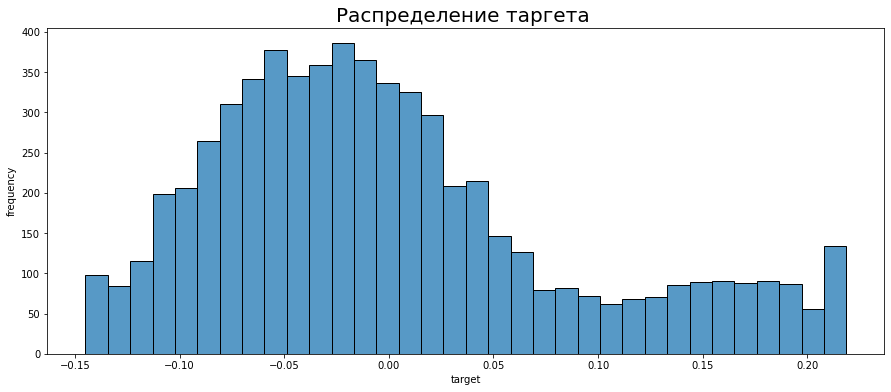

In [112]:
plt.figure(figsize=(15, 6))
plt.title('Распределение таргета ', fontsize=20)
sns.histplot(df_train, x='target')
sns.color_palette('pastel')
plt.xlabel('target')
plt.ylabel('frequency')

plt.show()

In [134]:
print(f'Имеем распределение со средним {df_train.target.mean():.3f} и стандартным отклонением {df_train.target.std():.2f}')

Имеем распределение со средним 0.001 и стандартным отклонением 0.09


In [75]:
df_train['address_rus'][1343]

'Магаданская улица, 31, посёлок Хандыга, Томпонский муниципальный район, Республика Саха (Якутия), Россия, 678720'

Сделаем промежуточный вывод о структуре данных и потенциальных проблемах. По записи 1343 (см. ячейку выше) можно видеть муниципальный формат записи адреса. В муниципальном делении указывают структуры местного самоуправления, например, регион, районы, сельские и городские поселения, муниципальные округа. Данный факт усложняет формат записи адреса для его парсинга на составлящие. Также имеются записи о банкоматах в нашем датасете, адресов на русском с географическими координатами которых нет вовсе.